In [1]:
import pygplates
import os
import numpy as np
from skimage import measure
import paleogeography as pg
import polygon_processing as pp
import matplotlib.pyplot as plt

%matplotlib inline


#os.system('gmt grdfilter /Users/Simon/Data/SedThickness/GEBCO1m/GridOne_5m.nc -Gtest.nc -Fg200e -fg -D4 -Vl')

gridX,gridY,gridZ = pg.load_netcdf('/Users/Simon/Data/SedThickness/GEBCO1m/test.nc')

bi = gridZ+1000
sampling = gridX[1]-gridX[0]

pad_hor = np.zeros((1,bi.shape[1]))
pad_ver = np.zeros((bi.shape[0]+2,1))
pad1 = np.vstack((pad_hor,bi,pad_hor))      # add row of zeros to top and bottom
pad2 = np.hstack((pad_ver,pad1,pad_ver))    # add row of zeros to left and right
#pad3 = np.hstack((pad2,pad_ver))
contours = measure.find_contours(pad2, 800, fully_connected='low')
## --- end

contour_polygons = []
contour_features = []

for n,cp in enumerate(contours):

    # To handle edge effects again - strip off parts of polygon
    # due to padding, and adjust from image coordinates to long/lat
    # --- start
    cp[:,1] = (cp[:,1]*sampling)-sampling
    cp[:,0] = (cp[:,0]*sampling)-sampling
    cp[np.where(cp[:,0]<0.),0] = 0
    cp[np.where(cp[:,0]>180.),0] = 180
    cp[np.where(cp[:,1]<0.),1] = 0
    cp[np.where(cp[:,1]>360.),1] = 360
    ## --- end

    cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
    contour_polygons.append(cpf)

    feature = pygplates.Feature()
    feature.set_geometry(cpf)
    contour_features.append(feature)


area_threshold = 0.001
sieve_polygons_t1 = pp.polygon_area_threshold(contour_features,area_threshold)
    
#plt.imshow(bi)
#plt.figure(figsize=(16,7))
sieve_polygons_t11 = []
for feature in sieve_polygons_t1:
    if feature.get_geometry().get_area() > np.pi*2:
        feature.set_geometry(pygplates.PolygonOnSphere(np.flipud(feature.get_geometry().to_lat_lon_array())))
        
    sieve_polygons_t11.append(feature)
    #plt.plot(feature.get_geometry().to_lat_lon_array()[:,1],feature.get_geometry().to_lat_lon_array()[:,0])

#pygplates.FeatureCollection(sieve_polygons_t1).write('present_day_mountain_outlines_m200m.gmt')


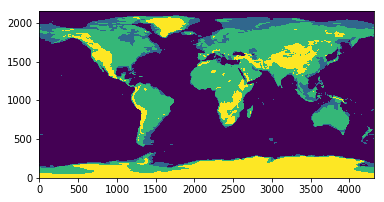

In [2]:

#####################################
#####################################
import xarray as xr

import os

# load global topography

gridX,gridY,gridZ = pg.load_netcdf('/Users/Simon/Data/SedThickness/GEBCO1m/test.nc')
#gridX,gridY,gridZ = pg.load_netcdf('/Users/Simon/Data/GMTdata/hawaii2017/earth_relief_10m.grd')

# gdal complains if latitudes are outside 90 degrees, so remove top and bottom rows
gridZ = gridZ[1:-1,:]
gridY = gridY[1:-1]

# make a grid of zeros, then replace values by incrementally increasinf integers for each higher level of topography
tmp = np.zeros(gridZ.shape)
tmp[gridZ>-500] = 1
tmp[gridZ>0] = 2
tmp[gridZ>1000] = 3

plt.imshow(tmp,origin='lower')


present_day_paleogeography.gmt


/Users/Simon/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


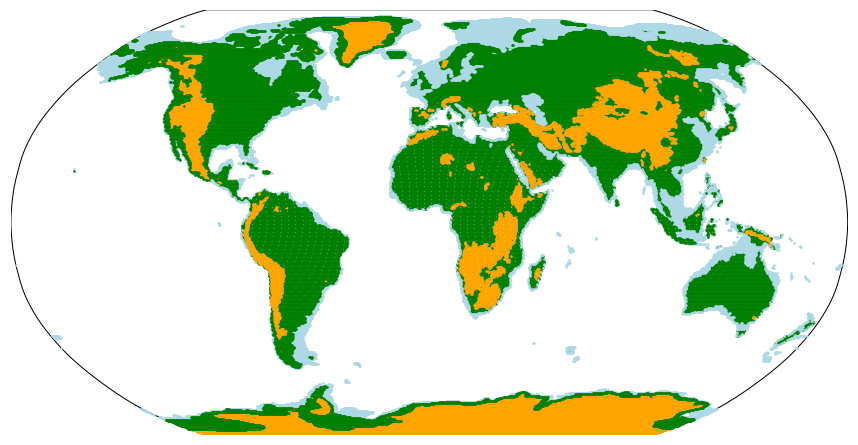

In [3]:
# write the integer category grid to a file
ds = xr.DataArray(tmp,
                  coords=[('lat',gridY),('lon',gridX)])
ds.to_netcdf('present_day_topo_as_classes.nc',format='NETCDF3_CLASSIC')

# use gdal polygonise to create polygons mapping the categories
os.system('/Users/Simon/anaconda/bin/gdal_polygonize.py /Users/Simon/GIT/paleotopography/present_day_topo_as_classes.nc -f "GMT" . tmp DN')
#os.system('/Users/Simon/anaconda/bin/gdal_polygonize.py')

features = pygplates.FeatureCollection('tmp.gmt')

pg_features = []

for feature in features:
    #if feature.get_shapefile_attribute('DN')==0:
    #    feature.set_shapefile_attribute('Layer','do')
    if feature.get_shapefile_attribute('DN')==1:
        feature.set_shapefile_attribute('Layer','sm')
        pg_features.append(feature)
    elif feature.get_shapefile_attribute('DN')==2:
        feature.set_shapefile_attribute('Layer','lm')
        pg_features.append(feature)
    elif feature.get_shapefile_attribute('DN')==3:
        feature.set_shapefile_attribute('Layer','m')
        pg_features.append(feature)
    #else:
    #    feature.set_shapefile_attribute('Layer','')

pygplates.FeatureCollection(pg_features).write('present_day_paleogeography.gmt')

reload(pg)
rotation_model = pygplates.RotationModel('../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles/Global_EB_250-0Ma_GK07_Matthews++.rot')

pg_features = pg.load_paleogeography('present_day_paleogeography.gmt',single_file=True,env_field='Layer')

pg_points = pg.rasterise_paleogeography(pg_features,rotation_model,0,masking='Outside')

#for feature in pg_features:
#    print feature.get_shapefile_attribute('Layer')

env_color_dict = {'lm':'green',
                  'm':'orange',
                  'sm':'lightblue',
                  'i':'blue',
                  'do':'black',
                  '':'pink'}

plt.figure(figsize=(15,8))

m = pg.paleogeography_points_basemap(pg_points,env_color_dict,fill_color=None,markersize=3)

plt.show()


In [4]:
import sys
del sys.modules['pygplates']
sys.path.append('/Applications/QGIS.app/Contents/Resources/python')
import qgis.core

import os
import os.path
from qgis import *
from qgis.core import *
#QgsApplication.setPrefixPath("/usr", True)  # in Ubuntu 12.04 repository installation /usr/bin/qgis 
#QgsApplication.initQgis()
from qgis.analysis import * 


shpA = QgsVectorLayer('present_day_paleogeography.gmt',"layerA","ogr")

shpB = QgsVectorLayer('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Shapefile/Muller_etal_AREPS_2016_StaticPolygons.shp',"layerB","ogr")

dst_shp = './tmp3.shp'

QgsOverlayAnalyzer().intersection( shpA , shpB  , dst_shp )
QgsApplication.exitQgis()
